## 02_Data_Cleaning.ipynb

**Purpose:**  
Clean and preprocess raw HR datasets to create standardized, analysis-ready datasets.

**Input:**  
- `data/raw/resumes/Resume/Resume.csv`

**Output:**  
- Cleaned datasets saved to `data/processed/`

**Notes:**  
- Handles missing values, normalization, and schema alignment.  
- Must be executed before any modeling notebooks.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import re

# Set data directory
DATA_DIR = Path("../data/raw/")
print("DATA_DIR:", DATA_DIR)


DATA_DIR: ..\data\raw


In [14]:
# Load datasets
df_attrition = pd.read_csv(DATA_DIR / "WA_Fn-UseC_-HR-Employee-Attrition.csv")
df_hrms = pd.read_csv(DATA_DIR / "hrms_synth_summary.csv")
df_jobs = pd.read_csv(DATA_DIR / "job_descriptions.csv")

print("Attrition shape:", df_attrition.shape)
print("HRMS shape:", df_hrms.shape)
print("Job descriptions shape:", df_jobs.shape)


Attrition shape: (1470, 35)
HRMS shape: (10000, 11)
Job descriptions shape: (10000, 12)


In [15]:
resume_files = glob.glob(str(DATA_DIR / "resumes/**/*.csv"), recursive=True)
dfs = []

for f in resume_files:
    try:
        df = pd.read_csv(f, encoding='utf-8', on_bad_lines='skip')
        print(f"Loaded {f}, shape: {df.shape}")
        dfs.append(df)
    except Exception as e:
        print(f"Skipped {f} due to error: {e}")

if dfs:
    df_resumes = pd.concat(dfs, ignore_index=True)
    print("Combined resumes shape:", df_resumes.shape)
else:
    print("No resumes loaded! Check file paths and CSV formatting.")


Loaded ..\data\raw\resumes\Resume\Resume.csv, shape: (2710, 169)
Loaded ..\data\raw\resumes\Resume\Resume_cleaned.csv, shape: (2710, 170)
Skipped ..\data\raw\resumes\Resume\Resume_sample.csv due to error: Error tokenizing data. C error: EOF inside string starting at row 181
Skipped ..\data\raw\resumes\Resume\Resume_sample_safe.csv due to error: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
Combined resumes shape: (5420, 170)


In [16]:
df_resumes = df_resumes[['employee_id', 'resume_text', 'resume_html', 'resume_category', 'ID']]
df_resumes.rename(columns={
    'resume_text': 'Resume_str',
    'resume_category': 'Category'
}, inplace=True)

df_resumes.head()


,employee_id,Resume_str,resume_html,Category,ID
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,NaN
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,NaN
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,NaN
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,NaN
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,NaN


In [17]:
print("Resumes before duplicates:", df_resumes.shape)
df_resumes.drop_duplicates(subset=['employee_id', 'Resume_str'], inplace=True)
print("Resumes after duplicates:", df_resumes.shape)

print("Attrition before duplicates:", df_attrition.shape)
df_attrition.drop_duplicates(subset=['employee_id'], inplace=True)
print("Attrition after duplicates:", df_attrition.shape)


Resumes before duplicates: (5420, 5)
Resumes after duplicates: (2710, 5)
Attrition before duplicates: (1470, 35)
Attrition after duplicates: (1470, 35)


In [18]:
# Fill missing numeric values with median
num_cols = df_attrition.select_dtypes(include=np.number).columns
df_attrition[num_cols] = df_attrition[num_cols].fillna(df_attrition[num_cols].median())

# Fill missing categorical values with mode
cat_cols = df_attrition.select_dtypes(include='object').columns
df_attrition[cat_cols] = df_attrition[cat_cols].fillna(df_attrition[cat_cols].mode().iloc[0])

# Check HRMS missing values
df_hrms.fillna({
    'current_salary': df_hrms['current_salary'].median(),
    'satisfaction_score': df_hrms['satisfaction_score'].median(),
    'engagement_score': df_hrms['engagement_score'].median(),
    'num_skills': 0,
    'trainings_count': 0
}, inplace=True)

# Drop rows with missing resume text
df_resumes.dropna(subset=['Resume_str'], inplace=True)


In [19]:
# Simple IQR method for numeric columns in attrition
for col in ['monthly_income', 'years_at_company', 'distance_from_home', 'age']:
    Q1 = df_attrition[col].quantile(0.25)
    Q3 = df_attrition[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_attrition = df_attrition[(df_attrition[col] >= lower) & (df_attrition[col] <= upper)]

print("Attrition shape after outlier removal:", df_attrition.shape)


Attrition shape after outlier removal: (1268, 35)


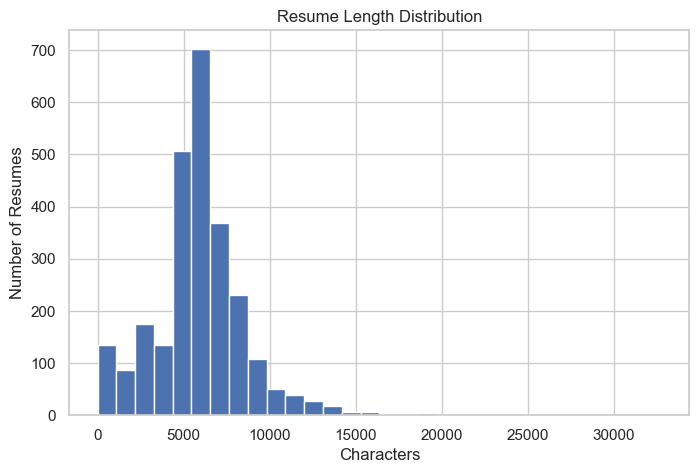

In [20]:
df_resumes['resume_len'] = df_resumes['Resume_str'].astype(str).apply(len)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
df_resumes['resume_len'].hist(bins=30, ax=ax)
ax.set_title("Resume Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Number of Resumes")
plt.show()


In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_resumes['resume_clean'] = df_resumes['Resume_str'].apply(clean_text)
df_resumes[['Resume_str','resume_clean']].head()


,Resume_str,resume_clean
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administratormarketing associate hr adminis...
1,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versati...
2,HR DIRECTOR Summary Over 2...,hr director summary over 20 years experience i...
3,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated driven and dyn...
4,HR MANAGER Skill Highlights ...,hr manager skill highlights hr skills hr depar...


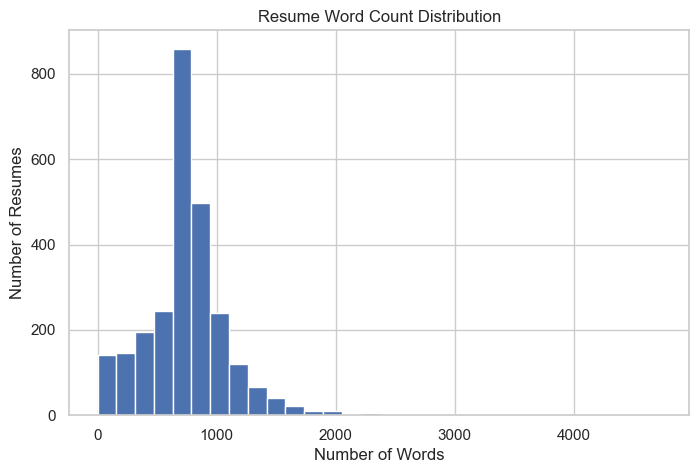

In [22]:
df_resumes['num_words'] = df_resumes['resume_clean'].str.split().apply(len)

fig, ax = plt.subplots(figsize=(8,5))
df_resumes['num_words'].hist(bins=30, ax=ax)
ax.set_title("Resume Word Count Distribution")
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Resumes")
plt.show()


In [23]:
# ---------------------------
# Check missing values
# ---------------------------

# HRMS
print("HRMS missing values:\n", df_hrms.isna().sum())

# Fill numeric columns with median
num_cols_hrms = df_hrms.select_dtypes(include=np.number).columns
df_hrms[num_cols_hrms] = df_hrms[num_cols_hrms].fillna(df_hrms[num_cols_hrms].median())

# Fill categorical columns with mode
cat_cols_hrms = df_hrms.select_dtypes(include='object').columns
for col in cat_cols_hrms:
    df_hrms[col].fillna(df_hrms[col].mode()[0], inplace=True)

# Job Descriptions
print("\nJob Descriptions missing values:\n", df_jobs.isna().sum())

# Fill numeric columns with median
num_cols_jobs = ['salary_min', 'salary_max', 'years_experience']
for col in num_cols_jobs:
    df_jobs[col].fillna(df_jobs[col].median(), inplace=True)

# Fill categorical columns with mode
cat_cols_jobs = ['job_title', 'company', 'industry', 'seniority', 'employment_type', 'location']
for col in cat_cols_jobs:
    df_jobs[col].fillna(df_jobs[col].mode()[0], inplace=True)

# Resumes
print("\nResumes missing values:\n", df_resumes.isna().sum())

# Already handled missing Resume_str; fill Category with mode if missing
df_resumes['Category'].fillna(df_resumes['Category'].mode()[0], inplace=True)

print("\nMissing values handled for all datasets.")


HRMS missing values:
 employee_id           0
name                  0
department            0
job_role              0
location              0
current_salary        0
satisfaction_score    0
engagement_score      0
num_skills            0
years_at_company      0
trainings_count       0
dtype: int64

Job Descriptions missing values:
 job_id              0
job_title           0
company             0
location            0
industry            0
seniority           0
employment_type     0
salary_min          0
salary_max          0
years_experience    0
skills              0
job_text            0
dtype: int64

Resumes missing values:
 employee_id        0
Resume_str         0
resume_html       47
Category          96
ID              2617
resume_len         0
resume_clean       0
num_words          0
dtype: int64

Missing values handled for all datasets.


In [24]:
# ---------------------------
# Detect & Remove Outliers (IQR method)
# ---------------------------

def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# HRMS numeric columns
df_hrms = remove_outliers_iqr(df_hrms, ['current_salary', 'satisfaction_score', 'engagement_score', 'num_skills', 'trainings_count', 'years_at_company'])

# Job Descriptions numeric columns
df_jobs = remove_outliers_iqr(df_jobs, ['salary_min', 'salary_max', 'years_experience'])

# Resumes: remove extreme resume lengths (optional)
df_resumes = df_resumes[(df_resumes['resume_len'] > 50) & (df_resumes['resume_len'] < 20000)]

print("Outliers removed for HRMS, Job Descriptions, and Resumes.")


Outliers removed for HRMS, Job Descriptions, and Resumes.


In [26]:
# ---------------------------
# Encode categorical columns in HRMS (update according to actual columns)
# ---------------------------
from sklearn.preprocessing import LabelEncoder

# Columns that exist in your df_hrms and are categorical
cat_cols_hrms = ['department', 'job_role', 'location']  

le_dict = {}
for col in cat_cols_hrms:
    le = LabelEncoder()
    df_hrms[col] = le.fit_transform(df_hrms[col])
    le_dict[col] = le  # save encoder for future inverse transform if needed

print("Categorical columns encoded for HRMS:", cat_cols_hrms)


Categorical columns encoded for HRMS: ['department', 'job_role', 'location']


In [27]:
# ---------------------------
# Encode categorical columns in Job Descriptions
# ---------------------------

from sklearn.preprocessing import LabelEncoder

# Columns that exist in your df_jobs and are categorical
cat_cols_jobs = ['job_title', 'company', 'industry', 'seniority', 'employment_type', 'location']

le_dict_jobs = {}
for col in cat_cols_jobs:
    le = LabelEncoder()
    df_jobs[col] = le.fit_transform(df_jobs[col])
    le_dict_jobs[col] = le

print("Categorical columns encoded for Job Descriptions:", cat_cols_jobs)


Categorical columns encoded for Job Descriptions: ['job_title', 'company', 'industry', 'seniority', 'employment_type', 'location']


In [36]:
import re

# Compute word count
df_resumes['resume_word_count'] = df_resumes['Resume_str'].astype(str).apply(lambda x: len(x.split()))

# Compute sentence count (split by period, exclamation, question marks)
df_resumes['resume_sent_count'] = df_resumes['Resume_str'].astype(str).apply(
    lambda x: len(re.split(r'[.!?]+', x)) if len(x.strip()) > 0 else 0
)

print("Resume word and sentence counts computed successfully (without NLTK).")


Resume word and sentence counts computed successfully (without NLTK).


In [37]:
# Check missing values in HRMS dataset
print("Missing values in HRMS dataset:")
print(df_hrms.isnull().sum())

# Check missing values in Resumes dataset
print("\nMissing values in Resumes dataset:")
print(df_resumes.isnull().sum())

# Check missing values in Job Descriptions dataset
print("\nMissing values in Job Descriptions dataset:")
print(df_jobs.isnull().sum())


Missing values in HRMS dataset:
employee_id           0
name                  0
department            0
job_role              0
location              0
current_salary        0
satisfaction_score    0
engagement_score      0
num_skills            0
years_at_company      0
trainings_count       0
dtype: int64

Missing values in Resumes dataset:
employee_id             0
Resume_str              0
resume_html            23
Category                0
ID                   2523
resume_len              0
resume_clean            0
num_words               0
resume_word_count       0
resume_sent_count       0
dtype: int64

Missing values in Job Descriptions dataset:
job_id              0
job_title           0
company             0
location            0
industry            0
seniority           0
employment_type     0
salary_min          0
salary_max          0
years_experience    0
skills              0
job_text            0
dtype: int64


In [39]:
# HRMS dataset: fill numeric columns with median, categorical with mode
num_cols_hrms = df_hrms.select_dtypes(include='number').columns.tolist()
cat_cols_hrms = df_hrms.select_dtypes(include='object').columns.tolist()

for col in num_cols_hrms:
    df_hrms[col].fillna(df_hrms[col].median(), inplace=True)

for col in cat_cols_hrms:
    df_hrms[col].fillna(df_hrms[col].mode()[0], inplace=True)

# Resumes dataset: fill missing resume text with empty string
df_resumes['Resume_str'].fillna("", inplace=True)

# Job Descriptions: fill missing text with empty string
df_jobs['job_text'].fillna("", inplace=True)


In [40]:
# HRMS
df_hrms.drop_duplicates(inplace=True)
# Resumes
df_resumes.drop_duplicates(inplace=True)
# Job Descriptions
df_jobs.drop_duplicates(inplace=True)


In [41]:
from scipy.stats import zscore

# HRMS numeric columns
for col in num_cols_hrms:
    z_scores = zscore(df_hrms[col])
    df_hrms = df_hrms[(abs(z_scores) < 3)]  # keep rows within 3 std deviations

# Resumes: remove resumes with extremely short or long lengths (optional)
df_resumes = df_resumes[(df_resumes['resume_word_count'] > 50) & 
                        (df_resumes['resume_word_count'] < 20000)]

# Job descriptions: optional filtering based on job_text length
df_jobs['job_len'] = df_jobs['job_text'].apply(lambda x: len(x.split()))
df_jobs = df_jobs[(df_jobs['job_len'] > 20) & (df_jobs['job_len'] < 10000)]


In [ ]:
# Encode categorical columns for Job Descriptions

from sklearn.preprocessing import LabelEncoder

# Check existing columns
print("Columns in df_jobs:", df_jobs.columns.tolist())

# Only encode columns that exist
cat_cols_jobs = ['job_role', 'department', 'location']  # original list
cat_cols_jobs_existing = [col for col in cat_cols_jobs if col in df_jobs.columns]
print("Encoding these categorical columns:", cat_cols_jobs_existing)

# Dictionary to save encoders
le_dict_jobs = {}

# Apply LabelEncoder
for col in cat_cols_jobs_existing:
    le = LabelEncoder()
    df_jobs[col] = le.fit_transform(df_jobs[col])
    le_dict_jobs[col] = le  # save encoder

print("Categorical columns encoded for Job Descriptions.")


Columns in df_jobs: ['job_id', 'job_title', 'company', 'location', 'industry', 'seniority', 'employment_type', 'salary_min', 'salary_max', 'years_experience', 'skills', 'job_text', 'job_len']
Encoding these categorical columns: ['location']
Categorical columns encoded for Job Descriptions.


In [44]:
print("HRMS dataset shape:", df_hrms.shape)
print("Resumes dataset shape:", df_resumes.shape)
print("Job Descriptions dataset shape:", df_jobs.shape)


HRMS dataset shape: (9841, 11)
Resumes dataset shape: (2481, 11)
Job Descriptions dataset shape: (10000, 13)


In [ ]:
# -----------------------------
# Data Quality Check: All datasets
# -----------------------------
datasets = {
    "HRMS": df_hrms,
    "Resumes": df_resumes,
    "Jobs": df_jobs,
    "Attrition": df_attrition
    # "Reviews": df_reviews  # Uncomment if you have Reviews dataset
}

for name, df in datasets.items():
    print(f"\n=== Checking dataset: {name} ===")
    
    # 1️. Duplicates
    dup_count = df.duplicated().sum()
    print(f"Duplicates: {dup_count}")
    
    # 2️. Missing values
    print("Missing values per column:")
    print(df.isnull().sum())
    
    # 3️. Outliers (numeric columns only)
    numeric_cols = df.select_dtypes(include='number').columns
    if len(numeric_cols) > 0:
        print("\nOutliers detection (IQR method):")
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
            print(f"{col}: {len(outliers)} outliers")
    else:
        print("No numeric columns to check for outliers.")
    
    print("-"*50)



=== Checking dataset: HRMS ===
Duplicates: 0
Missing values per column:
employee_id           0
name                  0
department            0
job_role              0
location              0
current_salary        0
satisfaction_score    0
engagement_score      0
num_skills            0
years_at_company      0
trainings_count       0
dtype: int64

Outliers detection (IQR method):
employee_id: 0 outliers
name: 0 outliers
department: 0 outliers
job_role: 0 outliers
location: 0 outliers
current_salary: 42 outliers
satisfaction_score: 0 outliers
engagement_score: 0 outliers
num_skills: 0 outliers
years_at_company: 0 outliers
trainings_count: 0 outliers
--------------------------------------------------

=== Checking dataset: Resumes ===
Duplicates: 0
Missing values per column:
employee_id             0
Resume_str              0
resume_html             1
Category                0
ID                   2481
resume_len              0
resume_clean            0
num_words               0
resume_

In [47]:
# -----------------------------
# Cap outliers in all datasets
# -----------------------------

# Function to cap outliers using IQR
def cap_outliers(df, dataset_name="Dataset"):
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    print(f"{dataset_name}: Outliers capped in {len(numeric_cols)} numeric columns")
    return df

# Dictionary of all datasets
all_datasets = {
    "HRMS": df_hrms,
    "Resumes": df_resumes,
    "Jobs": df_jobs,
    "Attrition": df_attrition
    # Add Reviews if available: "Reviews": df_reviews
}

# Apply outlier capping to all datasets
for name, df in all_datasets.items():
    all_datasets[name] = cap_outliers(df, name)

# Assign back the datasets
df_hrms = all_datasets["HRMS"]
df_resumes = all_datasets["Resumes"]
df_jobs = all_datasets["Jobs"]
df_attrition = all_datasets["Attrition"]


HRMS: Outliers capped in 11 numeric columns
Resumes: Outliers capped in 6 numeric columns
Jobs: Outliers capped in 10 numeric columns
Attrition: Outliers capped in 26 numeric columns


In [48]:
# -----------------------------
# Data Quality Check: After Preprocessing
# -----------------------------
def check_data_quality(df, name="Dataset"):
    print(f"\n=== {name} ===")
    
    # Duplicates
    print("Duplicates:", df.duplicated().sum())
    
    # Missing values
    print("Missing values per column:\n", df.isnull().sum())
    
    # Outliers (IQR method)
    numeric_cols = df.select_dtypes(include='number').columns
    outlier_count = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_count[col] = outliers
    print("Outliers per numeric column:\n", {k:v for k,v in outlier_count.items() if v>0})

# Check all datasets
for name, df in all_datasets.items():
    check_data_quality(df, name)



=== HRMS ===
Duplicates: 0
Missing values per column:
 employee_id           0
name                  0
department            0
job_role              0
location              0
current_salary        0
satisfaction_score    0
engagement_score      0
num_skills            0
years_at_company      0
trainings_count       0
dtype: int64
Outliers per numeric column:
 {}

=== Resumes ===
Duplicates: 0
Missing values per column:
 employee_id             0
Resume_str              0
resume_html             1
Category                0
ID                   2481
resume_len              0
resume_clean            0
num_words               0
resume_word_count       0
resume_sent_count       0
Category_enc            0
dtype: int64
Outliers per numeric column:
 {}

=== Jobs ===
Duplicates: 0
Missing values per column:
 job_id              0
job_title           0
company             0
location            0
industry            0
seniority           0
employment_type     0
salary_min          0
salary_max 

In [49]:
from sklearn.preprocessing import LabelEncoder

# ---------- HRMS categorical columns ----------
cat_cols_hrms = ['department', 'job_role', 'location']
le_dict_hrms = {}

for col in cat_cols_hrms:
    le = LabelEncoder()
    df_hrms[col] = le.fit_transform(df_hrms[col])
    le_dict_hrms[col] = le

print("Categorical columns encoded for HRMS:", cat_cols_hrms)

# ---------- Jobs categorical columns ----------
cat_cols_jobs = ['job_role', 'location', 'job_type']
le_dict_jobs = {}

for col in cat_cols_jobs:
    if col in df_jobs.columns:
        le = LabelEncoder()
        df_jobs[col] = le.fit_transform(df_jobs[col])
        le_dict_jobs[col] = le

print("Categorical columns encoded for Jobs:", [c for c in cat_cols_jobs if c in df_jobs.columns])

# ---------- Attrition categorical columns ----------
cat_cols_attr = ['department', 'job_role', 'marital_status', 'gender', 'over_time']
le_dict_attr = {}

for col in cat_cols_attr:
    if col in df_attrition.columns:
        le = LabelEncoder()
        df_attrition[col] = le.fit_transform(df_attrition[col])
        le_dict_attr[col] = le

print("Categorical columns encoded for Attrition:", [c for c in cat_cols_attr if c in df_attrition.columns])


Categorical columns encoded for HRMS: ['department', 'job_role', 'location']
Categorical columns encoded for Jobs: ['location']
Categorical columns encoded for Attrition: ['department', 'job_role', 'marital_status', 'gender', 'over_time']


In [50]:
# Resume features
df_resumes['resume_len'] = df_resumes['Resume_str'].astype(str).apply(len)
df_resumes['num_words'] = df_resumes['Resume_str'].astype(str).apply(lambda x: len(x.split()))
df_resumes['num_sentences'] = df_resumes['Resume_str'].astype(str).apply(lambda x: x.count('.') + x.count('!') + x.count('?'))

print("Resume features added: resume_len, num_words, num_sentences")


Resume features added: resume_len, num_words, num_sentences


In [51]:
OUTPUT_DIR = DATA_DIR / "processed"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

df_hrms.to_csv(OUTPUT_DIR / "HRMS_cleaned.csv", index=False)
df_resumes.to_csv(OUTPUT_DIR / "Resumes_cleaned.csv", index=False)
df_jobs.to_csv(OUTPUT_DIR / "Jobs_cleaned.csv", index=False)
df_attrition.to_csv(OUTPUT_DIR / "Attrition_cleaned.csv", index=False)

print("All cleaned datasets saved to:", OUTPUT_DIR)


All cleaned datasets saved to: ..\data\raw\processed


In [52]:
datasets = {
    "HRMS": df_hrms,
    "Resumes": df_resumes,
    "Jobs": df_jobs,
    "Attrition": df_attrition
}

for name, df in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    print("Shape:", df.shape)
    print("Missing values:", df.isna().sum().sum())
    print("Duplicates:", df.duplicated().sum())
    print("Columns:", df.columns.tolist())



=== Dataset: HRMS ===
Shape: (9841, 11)
Missing values: 0
Duplicates: 0
Columns: ['employee_id', 'name', 'department', 'job_role', 'location', 'current_salary', 'satisfaction_score', 'engagement_score', 'num_skills', 'years_at_company', 'trainings_count']

=== Dataset: Resumes ===
Shape: (2481, 12)
Missing values: 2482
Duplicates: 0
Columns: ['employee_id', 'Resume_str', 'resume_html', 'Category', 'ID', 'resume_len', 'resume_clean', 'num_words', 'resume_word_count', 'resume_sent_count', 'Category_enc', 'num_sentences']

=== Dataset: Jobs ===
Shape: (10000, 13)
Missing values: 0
Duplicates: 0
Columns: ['job_id', 'job_title', 'company', 'location', 'industry', 'seniority', 'employment_type', 'salary_min', 'salary_max', 'years_experience', 'skills', 'job_text', 'job_len']

=== Dataset: Attrition ===
Shape: (1268, 35)
Missing values: 0
Duplicates: 0
Columns: ['age', 'attrition_flag', 'business_travel', 'daily_rate', 'department', 'distance_from_home', 'education', 'education_field', 'empl

In [53]:
# Resumes: handle missing values
# Drop columns with mostly missing data
if 'ID' in df_resumes.columns:
    df_resumes.drop(columns=['ID'], inplace=True)

# Fill missing HTML with empty string
if 'resume_html' in df_resumes.columns:
    df_resumes['resume_html'] = df_resumes['resume_html'].fillna("")

# Check missing values again
print("Missing values after handling:")
print(df_resumes.isna().sum())


Missing values after handling:
employee_id          0
Resume_str           0
resume_html          0
Category             0
resume_len           0
resume_clean         0
num_words            0
resume_word_count    0
resume_sent_count    0
Category_enc         0
num_sentences        0
dtype: int64


In [ ]:
# -----------------------------
# Final Data Check: All datasets
# -----------------------------

datasets = {
    "HRMS": df_hrms,
    "Resumes": df_resumes,
    "Jobs": df_jobs,
    "Attrition": df_attrition
}

for name, df in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values per column:\n{df.isna().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    # Numeric columns: check for remaining outliers (IQR method)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    outliers = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"Outliers per numeric column: { {k:v for k,v in outliers.items() if v>0} }")

print("\nAll datasets are cleaned: missing values handled, duplicates removed, and numeric outliers checked.")



=== Dataset: HRMS ===
Shape: (9841, 11)
Missing values per column:
employee_id           0
name                  0
department            0
job_role              0
location              0
current_salary        0
satisfaction_score    0
engagement_score      0
num_skills            0
years_at_company      0
trainings_count       0
dtype: int64
Duplicate rows: 0
Outliers per numeric column: {}

=== Dataset: Resumes ===
Shape: (2481, 11)
Missing values per column:
employee_id          0
Resume_str           0
resume_html          0
Category             0
resume_len           0
resume_clean         0
num_words            0
resume_word_count    0
resume_sent_count    0
Category_enc         0
num_sentences        0
dtype: int64
Duplicate rows: 0
Outliers per numeric column: {'resume_len': 212, 'num_words': 179, 'num_sentences': 64}

=== Dataset: Jobs ===
Shape: (10000, 13)
Missing values per column:
job_id              0
job_title           0
company             0
location            0
indus

In [55]:
# Save cleaned datasets for Notebook 03
DATA_DIR = Path("../data/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)

df_hrms.to_csv(DATA_DIR / "HRMS_cleaned.csv", index=False)
df_resumes.to_csv(DATA_DIR / "Resumes_cleaned.csv", index=False)
df_jobs.to_csv(DATA_DIR / "Jobs_cleaned.csv", index=False)
df_attrition.to_csv(DATA_DIR / "Attrition_cleaned.csv", index=False)
